In [17]:
import os
import pandas as pd
import time
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

data_dir_1 = '/workspaces/Final-Year-Project/Data/2023/'
file_list = os.listdir(data_dir_1)
sas_files = [file for file in file_list if file.endswith('.XPT') or file.endswith('.xpt')]

first_file_path = os.path.join(data_dir_1, sas_files[0])
merged_df = pd.read_sas(first_file_path, format='xport', encoding='iso-8859-1')

for file_name in sas_files[1:]:
    file_path = os.path.join(data_dir_1, file_name)
    df = pd.read_sas(file_path, format='xport', encoding='iso-8859-1')
    if 'SEQN' not in df.columns:
        continue  # Skip files missing SEQN
    merged_df = pd.merge(merged_df, df, on='SEQN', how='outer', suffixes=('', f'_{file_name}'))
    del df  # Free memory

merged_df = merged_df.select_dtypes(include=['float64'])

In [18]:
merged_df_cleaned = merged_df

def categorize_diabetes(row):    
    if (pd.notnull(row['LBXGH']) and row['LBXGH'] >= 5.7) or (pd.notnull(row['LBXGLU']) and row['LBXGLU'] >= 100):
        return 1  # Diabetes / At Risk
    else:
        return 0  # No Diabetes

merged_df_cleaned['Diabetes Status'] = merged_df_cleaned.apply(categorize_diabetes, axis=1)
merged_df_cleaned.drop(columns=['LBXGH', 'LBXGLU','LBDGLUSI'], inplace=True)

In [19]:
df = merged_df_cleaned

missing_percentage = df.isnull().mean() * 100

columns_to_drop = missing_percentage[missing_percentage > 65].index
df = df.drop(columns=columns_to_drop)

df = df.dropna(thresh=len(df.columns) * 0.9)

df = df.dropna(subset=['Diabetes Status'])

# Drop rows where any column contains the value 9
df = df[~(df == 9).any(axis=1)]

In [20]:
no_diabetes = df[df['Diabetes Status'] == 0]
diabetes = df[df['Diabetes Status'] == 1]

minority_class_size = min(len(no_diabetes), len(diabetes))

no_diabetes_downsampled = resample(no_diabetes, replace=False, n_samples=minority_class_size, random_state=42)
diabetes_downsampled = resample(diabetes, replace=False, n_samples=minority_class_size, random_state=42)

df_balanced = pd.concat([no_diabetes_downsampled, diabetes_downsampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [21]:
df_corr = df_balanced.corr()

df_top_filtered = df_corr['Diabetes Status'].abs()[df_corr['Diabetes Status'].abs() > 0.17]

columns_to_keep = df_top_filtered.index
df_filtered = df_balanced[columns_to_keep]

Text(0.5, 1.0, 'Correlation Matrix')

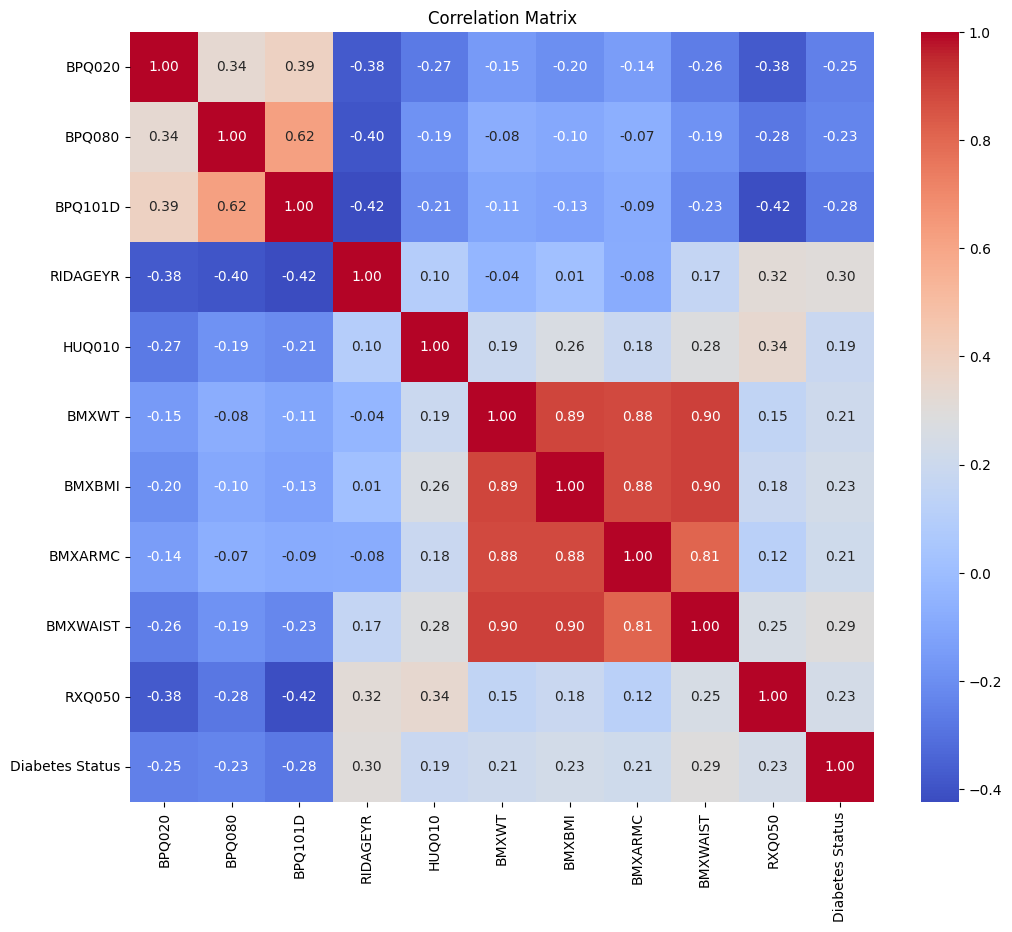

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix')

In [23]:
df_train_test, df_validate = train_test_split(df_filtered, test_size=0.1, random_state=42)

df_filtered.to_csv('/workspaces/Final-Year-Project/Cleaned Data/DataTopCorrelationData.csv', index=False)
df_validate.to_csv('/workspaces/Final-Year-Project/Cleaned Data/ValidationData.csv', index=False)
df_train_test.to_csv('/workspaces/Final-Year-Project/Cleaned Data/TrainTestData.csv', index=False)

print("Final Diabetes Status Distribution:\n", df_filtered['Diabetes Status'].value_counts())
print("Final Dataset Info:\n")
df_filtered.info()

Final Diabetes Status Distribution:
 Diabetes Status
1    1190
0    1190
Name: count, dtype: int64
Final Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2380 entries, 0 to 2379
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BPQ020           2380 non-null   float64
 1   BPQ080           2380 non-null   float64
 2   BPQ101D          2380 non-null   float64
 3   RIDAGEYR         2380 non-null   float64
 4   HUQ010           2380 non-null   float64
 5   BMXWT            2366 non-null   float64
 6   BMXBMI           2363 non-null   float64
 7   BMXARMC          2359 non-null   float64
 8   BMXWAIST         2337 non-null   float64
 9   RXQ050           1687 non-null   float64
 10  Diabetes Status  2380 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 204.7 KB
